# __GNNExplainer Tutorial__

Disclaimer: This tutorial assumes that you are familiar with Pytorch.

In this tutorial, We will use Pytorch-Geometric(https://pytorch-geometric.readthedocs.io/en/latest/)[[1]], which is a GNN library built on top of Pytorch.

This tutorial is based on the example provided by Pytorch-Geometric(https://github.com/rusty1s/pytorch_geometric/blob/master/examples/gnn_explainer.py).


[[1]] Fey, Matthias and Lenssen, Jan E. "Fast Graph Representation Learning with PyTorch Geometric." ICLR Workshop on Representation Learning on Graphs and Manifolds. 2019.

In [1]:
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt





RDKit WARNING: [22:48:10] Enabling RDKit 2019.09.3 jupyter extensions


# 1. Training a GNN with Pytorch-Geometric

## 1. Dataset

Here, we load our dataset. We use Cora as in Yang et al.[[1]],  which is readily provided by Pytorch-Geometric(https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html?highlight=cora#torch_geometric.datasets.Planetoid). This dataset is a node classification dataset: that is, given nodes and their features, the GNN must predict the correct label for the node. For each node, there is an input feature vector $x$ and label $y$. 

*Currently, the GNNExplainer provided by Pytorch-Geometric can only handle networks that are designed for __node classification__ tasks. Other tasks(node regression, graph classifiication, etc.) will result in an error.

### Reference Paper
[[1]] Yang, Zhilin, William Cohen, and Ruslan Salakhudinov. "Revisiting semi-supervised learning with graph embeddings." International conference on machine learning. 2016.


In [2]:
#Load the dataset
dataset = 'cora'
path = os.path.join(os.getcwd(), 'data', 'Planetoid')
train_dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())

# Since the dataset is comprised of a single huge graph, we extract that graph by indexing 0.
data = train_dataset[0]

# Since there is only 1 graph, the train/test split is done by masking regions of the graph. We split the last 500+500 nodes as val and test, and use the rest as the training data.
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1
data.val_mask = None
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1

## 2. Network
We define a network that is to be trained and explained by GNNExplainer.
We construct a simple graph neural network composed of 2 graph convolution layers(Kipf et al.).

In [3]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim=16, num_classes=1):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, num_classes)

    def forward(self, x, edge_index, data=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## 3. Training

Below is a standard Pytorch network training procedure.

In [9]:
epochs = 200
dim = 16


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=train_dataset.num_features, dim=dim, num_classes=train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [11]:
def test(model, data):
    model.eval()
    logits, accs = model(data.x, data.edge_index, data), []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [12]:
loss = 999.0
train_acc = 0.0
test_acc = 0.0

t = trange(epochs, desc="Stats: ", position=0)

for epoch in t:

    model.train()
    
    loss = 0

    data = data.to(device)
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data)

    # Since the data is a single huge graph, training on the training set is done by masking the nodes that are not in the training set.
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validate
    train_acc, test_acc = test(model, data)
    train_loss = loss
    
    t.set_description('[Train_loss:{:.6f} Train_acc: {:.4f}, Test_acc: {:.4f}]'.format(loss, train_acc, test_acc))

[Train_loss:1.505047 Train_acc: 0.4403, Test_acc: 0.4480]: 100%|██████████| 1000/1000 [00:09<00:00, 100.05it/s]


# 2. GNNExplainer

## 1. Instantiation

Now we use GNNExplainer on the network trained above by wrapping the model with the GNNExplainer wrapper class(https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=gnnexplainer#torch_geometric.nn.models.GNNExplainer). With explainer.explain_node() method, we cam fit GNNExplainer to explain a target node. This method must be supplied with a target node index(node_idx) and the graph(x, edge_index). The method then produces a node mask and a feature mask that reveals nodes/features that were important in producing such a prediction.



In [13]:
node_idx = 10
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)


Explain node 10: 100%|██████████| 200/200 [00:01<00:00, 115.71it/s]


## 2. Visualization
GNNExplainer supports visualization via Matplotlib. you can also supply the function with a threshold value deciding whether to obscure/reveal nodes and edges of certain importance values. The function returns the axes to the Matplotlib plot and a Networkx graph for additional control.

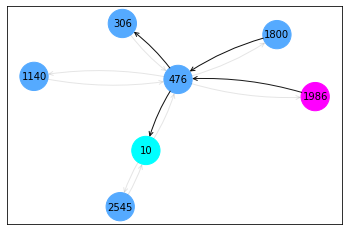

In [9]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()
